# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 't_subset_blueprint_2m_fix'
TITRATING_CELLTYPE = 't_effector'
TITRATING_CELLTYPE_ATLAS = 'immune_t_effector' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 20 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 2000000

# make sure the orders of the two list match
CELLTYPES = ['t_effector',
             't_reg', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']
ABRIDGED_NAMES = ['Teff', 'Treg', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]


# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          't_naive':0.16+0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
CELLTYPES = ['t_effector', 
             't_reg',
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']

ABRIDGED_NAMES = ['Teff', 'Treg', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.20, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                  0.008, 0.006, 0.004, 0.002, 0.001, 0] # % of total T-cells

# background cell type proportion (T is 23%)
WHOLE_BLOOD_ABUNDANCE = {'B':0.06,
                         'Mono':0.09,
                         'Neutro':0.57,
                         'NK':0.05}

# background: % of total T-cells (multipy with 0.2)
WHOLE_BLOOD_ABUNDANCE_T = {'t_naive':0.90,
                           't_reg':0.10}

PROPORTIONS = []
treg_titrating_proprotions = [] 
teff_titrating_proprotions = []
tnai_titrating_proprotions = []

for t, alpha in enumerate(TITRATION_LIST):  
    
    # T cell total to be 23 % 
    proportion_teff = 0.23 * alpha  # alpha is the titrating proportion
    proportion_treg = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_reg'] 
    proportion_tnai = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_naive'] 
    
    treg_titrating_proprotions.append(proportion_treg)
    teff_titrating_proprotions.append(proportion_teff)
    tnai_titrating_proprotions.append(proportion_tnai)
    
    proportion = [proportion_teff, 
                  proportion_treg, 
                  proportion_tnai,
                  WHOLE_BLOOD_ABUNDANCE['B'],
                  WHOLE_BLOOD_ABUNDANCE['NK'],
                  WHOLE_BLOOD_ABUNDANCE['Mono'],
                  WHOLE_BLOOD_ABUNDANCE['Neutro']]
    
    PROPORTIONS.append(proportion)


In [6]:
teff_titrating_proprotions

[0.046000000000000006,
 0.0345,
 0.023000000000000003,
 0.0184,
 0.0138,
 0.0092,
 0.0046,
 0.0023,
 0.00184,
 0.0013800000000000002,
 0.00092,
 0.00046,
 0.00023,
 0.0]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/t_subset_mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: t_effector
----------> Loading cell type: t_reg
----------> Loading cell type: t_naive
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.046000000000000006, 0.018400000000000003, 0.16560000000000002, 0.06, 0.05, 0.09, 0.57]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## Compute score matrix

In [ ]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [ ]:
# cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [ ]:
# %%time
# ridxs = ~cpg_map['cpg_index_hg38'].isna()
# hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
# hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [ ]:
# region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

# region_df['region_cpg_index_max'] -= 1
# region_df.sort_values('region_cpg_index_min', inplace=True)
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

# region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
# ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
# ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
# cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
# cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
# ridxs = (cg_count_hg19==cg_count_hg38)
# ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [ ]:
# ### Restrict to immune regions
# #-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# # BLUEPRINT immune regions
# ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.t_subset_same.atlas.tsv.gz'
# atlas = pd.read_csv(ATLAS_PATH, sep='\t')
# subset_region_set = set(atlas.region_id)
# #-----------------------------------------------------------------------------

# # filter regions down to regions of interest
# region_df = region_df[region_df['region_id'].isin(subset_region_set)]
# region_df.head()

In [ ]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, 
                                                 schema=RETURN_SCHEMA, 
                                                 kmers=KMERS, 
                                                 rates_leq=RATES_LEQ, 
                                                 rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

## Deconvolution

In [8]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [9]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

In [10]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(292, 11)

In [11]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.5 s, sys: 161 ms, total: 4.66 s
Wall time: 4.67 s


In [12]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

In [13]:

# dcnv.boxplot_titration_combined(list_of_deconvolution_dfs_naive=deconvolution_naive,
#                        list_of_deconvolution_dfs_nnls=deconvolution_nnls,
#                       cell_type=TITRATING_CELLTYPE_ATLAS,
#                       true_proportions=[round(x, 4) for x in teff_titrating_proprotions]
#                       )

In [14]:
# dcnv.boxplot_titration_zoom_combined(list_of_deconvolution_dfs_naive=deconvolution_naive,
#                        list_of_deconvolution_dfs_nnls=deconvolution_nnls,
#                       cell_type=TITRATING_CELLTYPE_ATLAS,
#                       true_proportions=[round(x, 4) for x in treg_titrating_proprotions]
#                       )

In [15]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [16]:
TITRATING_CELLTYPE_ATLAS

'immune_t_effector'

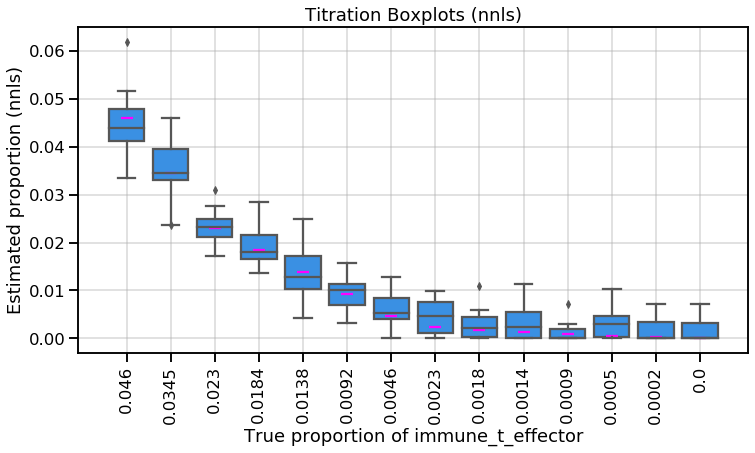

In [17]:

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [18]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

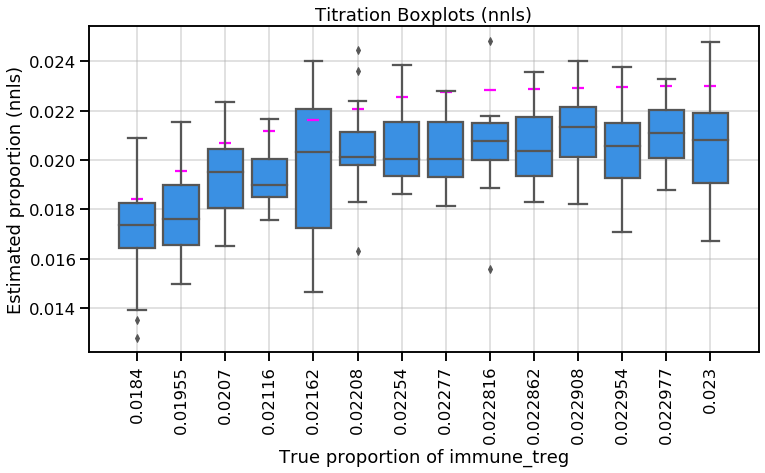

In [19]:

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_treg',
                      true_proportions=[round(x, 8) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [20]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

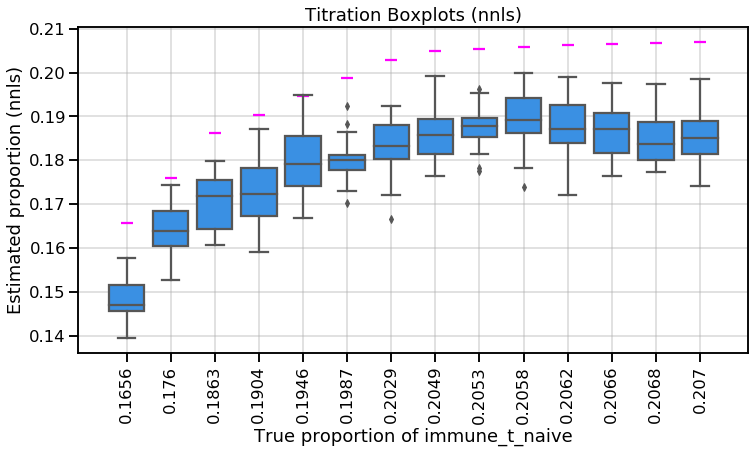

In [21]:
deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_naive',
                      true_proportions=[round(x, 4) for x in tnai_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [22]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

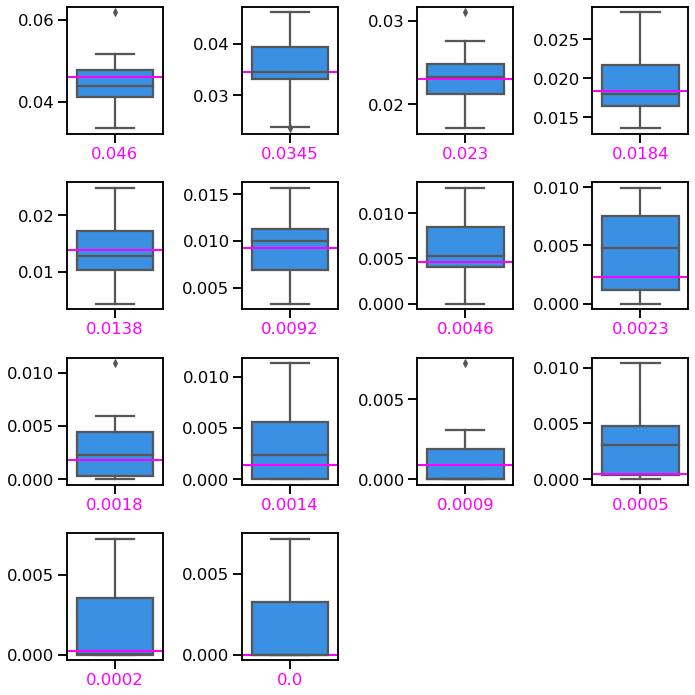

In [23]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls')

In [24]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_effector-wholeblood//methyl_score/'

In [25]:
deconvolution_nnls[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.059431,0.059334,0.058749,0.059659,0.058412,0.056763,0.062540,0.058095,0.059096,0.061188,0.061498,0.059252,0.062817,0.059940,0.060778,0.059042,0.057586,0.059010,0.059827,0.059880
immune_t_naive,0.147335,0.157610,0.143648,0.153300,0.145045,0.150982,0.149611,0.146773,0.143448,0.139334,0.145932,0.152060,0.151433,0.145761,0.144908,0.150416,0.146470,0.146701,0.156428,0.154684
immune_t_effector,0.043917,0.040769,0.040943,0.043841,0.051028,0.051604,0.040031,0.041324,0.043438,0.044835,0.051378,0.047542,0.041988,0.043090,0.046841,0.033554,0.048451,0.061814,0.039907,0.045601
immune_treg,0.020895,0.013929,0.018509,0.017620,0.017189,0.014971,0.018622,0.018034,0.018713,0.018155,0.016908,0.013534,0.017847,0.017400,0.017014,0.017163,0.017323,0.012806,0.020524,0.014905
immune_nk,0.047622,0.046913,0.047767,0.048128,0.047773,0.047034,0.048232,0.048190,0.049949,0.047407,0.049401,0.049212,0.047452,0.047278,0.045648,0.050645,0.047036,0.046980,0.049491,0.045351
immune_mono,0.097843,0.089346,0.097769,0.097290,0.094329,0.096629,0.095976,0.095283,0.101737,0.097908,0.102883,0.106456,0.104023,0.100591,0.102403,0.098980,0.103530,0.107077,0.105500,0.110661
immune_eosi,0.000000,0.000266,0.000000,0.000000,0.000000,0.001127,0.002232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000118,0.000000,0.000000
immune_neutro,0.558218,0.556919,0.561944,0.559017,0.556624,0.553033,0.557261,0.556145,0.554783,0.561868,0.558853,0.553809,0.557439,0.557406,0.555717,0.552756,0.557774,0.556037,0.556322,0.547902
immune_eryth,0.000953,0.000000,0.001180,0.000000,0.000210,0.000872,0.000000,0.001784,0.001658,0.000000,0.001713,0.000000,0.001242,0.000088,0.003120,0.000000,0.000444,0.000000,0.001784,0.000653


In [33]:
%%time

CELLTYPES = ['t_effector',
             't_reg',
            't_naive']

# load score data from all cell types
deconvolution_nnls = []

TITRATION_LIST = teff_titrating_proprotions
SCORE_VAR = 'frac_alpha_leq_25pct'
FILTER_COV = 20

for celltype in CELLTYPES: 
    EXPERIMENT_NAME = f'{celltype}-{BACKGROUND}/'            # <-- iterate over this
    EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
    SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'

    # iterate nnls deconvolition on each score_df
    deconv_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)
    
    deconvolution_nnls.append(deconv_nnls)

CPU times: user 13.7 s, sys: 99.5 ms, total: 13.8 s
Wall time: 13.8 s


In [34]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m_fix/t_naive-wholeblood//methyl_score/'

In [46]:
deconvolution_nnls[1][0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.059384,0.059504,0.058849,0.059645,0.058530,0.056807,0.062712,0.058413,0.058973,0.061012,0.061785,0.059327,0.062786,0.060055,6.093314e-02,0.059080,0.057668,0.059036,0.059763,0.059954
immune_t_naive,0.129630,0.140710,0.127208,0.133673,0.126404,0.135376,0.128846,0.131435,0.128091,0.126753,0.127985,0.138699,0.130392,0.128437,1.281850e-01,0.133435,0.131293,0.128315,0.143321,0.138119
immune_t_effector,0.039411,0.036046,0.035446,0.041025,0.045117,0.044658,0.039271,0.035441,0.029783,0.034032,0.045852,0.039879,0.037924,0.031846,3.694117e-02,0.023142,0.041526,0.050844,0.034668,0.036827
immune_treg,0.047123,0.039807,0.041431,0.043146,0.041204,0.040442,0.042672,0.042345,0.044213,0.045116,0.042378,0.037132,0.042408,0.041653,4.324076e-02,0.042431,0.041853,0.038161,0.042677,0.040269
immune_nk,0.047152,0.046868,0.047820,0.047721,0.047629,0.046877,0.048053,0.048017,0.050529,0.046992,0.049375,0.049155,0.047111,0.047520,4.533499e-02,0.050990,0.047398,0.047675,0.048883,0.045620
immune_mono,0.097194,0.089302,0.096853,0.097027,0.094128,0.095747,0.095432,0.094903,0.102822,0.096692,0.102559,0.106972,0.103995,0.100930,1.017125e-01,0.098647,0.102362,0.106168,0.105101,0.109959
immune_eosi,0.000000,0.000272,0.000000,0.000000,0.000000,0.001052,0.002248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000193,0.000000,0.000000
immune_neutro,0.557328,0.555639,0.560441,0.558235,0.556974,0.552341,0.556381,0.555375,0.555650,0.562092,0.558311,0.553626,0.556273,0.556029,5.560630e-01,0.552291,0.557458,0.554998,0.556104,0.547191
immune_eryth,0.001752,0.000000,0.000727,0.000000,0.000716,0.000347,0.000783,0.002202,0.002249,0.000230,0.002235,0.000000,0.001481,0.000442,2.977346e-03,0.000243,0.001167,0.000000,0.002256,0.001522


In [35]:
def lod95_detect_plot(titrating_celltypes, titrating_celltype_proportion, deconvolution_preds, detection_threshold, lod=0.95):
    # celltype atlas, deconvolution_predictions list(s), titration list, titrating cell type proportions, decision threshold
    # celltype atlas, deconvolution list(s), titration list, titrating cell type proportions, +/- tolerance
    # support 1 vs all
    # titrating_celltypes = ['immune_t_effector', 'immune_treg']
    # titrating_celltype_proportion = TITRATION_LIST
    # deconvolution_preds = deconvolution_nnls
    # detection_threshold =  0.005
    # lod = 0.95

    data = []
    lod95_value = []

    # <- start loop
    for celltype in titrating_celltypes:
        
        celltype_idx = titrating_celltypes.index(celltype)
        preds_for_celltype = deconvolution_preds[celltype_idx]

        p_detect = []

        for df in preds_for_celltype:
            m, n = df.shape
            phat = df[df.index == celltype]
            phat_boolean = phat > detection_threshold
            p_detected = sum(phat_boolean.values.squeeze()) / n
            p_detect.append(p_detected)

        ###### ----- plotting

        # Replace these with your data
        x_values = titrating_celltype_proportion
        y_values = p_detect 

        data.append((x_values, y_values))

        # Sorting the x_values and y_values in the order of x_values
        sorted_indices = np.argsort(x_values)
        x_values_sorted = np.array(x_values)[sorted_indices]
        y_values_sorted = np.array(y_values)[sorted_indices]

        if x_values_sorted[0] == 0:
            y_values_sorted[0] = 0

        # Interpolating to find the x-value
        y_target = lod
        x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
        lod95_value.append(x_target)


    for i, (x_values, y_values) in enumerate(data):
        name = titrating_celltypes[i]
        lod95 = round(lod95_value[i], 3)
        label = f'{name}: {lod95}'
        if x_values[-1] == 0:
            y_values[-1] = 0
        sns.scatterplot(x=x_values, y=y_values, label=label)
        sns.lineplot(x=x_values, y=y_values)

    # Set the limits and spacing of the x and y axes
    # plt.xticks(ticks=[i/10 for i in range(11)])
    # plt.yticks(ticks=[i/10 for i in range(11)])
    plt.xlim(0, 0.1)
    plt.ylim(0, 1)

    plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

    plt.grid(True, alpha=0.5)
    plt.gca().set_axisbelow(True)

    plt.xlabel('Cell Type Proportion')
    plt.ylabel('% Correctly Identified (x/20)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    


In [36]:
def lod95_within_proportion_plot(titrating_celltypes, titrating_celltype_proportion, deconvolution_preds, tolerance=0.3, lod=0.95):
    # celltype atlas, deconvolution_predictions list(s), titration list, titrating cell type proportions, decision threshold
    # celltype atlas, deconvolution list(s), titration list, titrating cell type proportions, +/- tolerance
    # support 1 vs all
    # titrating_celltypes = ['immune_t_effector', 'immune_treg']
    # titrating_celltype_proportion = TITRATION_LIST
    # deconvolution_preds = deconvolution_nnls
    # detection_threshold =  0.005
    # lod = 0.95

    data = []
    lod95_value = []

    # <- start loop
    for celltype in titrating_celltypes:
        
        celltype_idx = titrating_celltypes.index(celltype)
        preds_for_celltype = deconvolution_preds[celltype_idx]

        p_correct = []

        for i in range(0,len(preds_for_celltype)):
            df = preds_for_celltype[i]
            m, n = df.shape
            eps = titrating_celltype_proportion[i] * tolerance
            true_p = titrating_celltype_proportion[i]
            true_p_min = true_p - eps 
            true_p_max = true_p + eps
            phat = df[df.index == celltype]
            phat = phat.values.squeeze()
            phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
            p_correct.append(sum(phat_boolean) / n)

        ###### ----- plotting

        # Replace these with your data
        x_values = titrating_celltype_proportion
        y_values = p_correct

        data.append((x_values, y_values))

        # Sorting the x_values and y_values in the order of x_values
        sorted_indices = np.argsort(x_values)
        x_values_sorted = np.array(x_values)[sorted_indices]
        y_values_sorted = np.array(y_values)[sorted_indices]

        if x_values_sorted[0] == 0:
            y_values_sorted[0] = 0

        # Interpolating to find the x-value
        y_target = lod
        x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
        lod95_value.append(x_target)


    for i, (x_values, y_values) in enumerate(data):
        name = titrating_celltypes[i]
        lod95 = round(lod95_value[i], 3)
        label = f'{name}: {lod95}'
        if x_values[-1] == 0:
            y_values[-1] = 0
        sns.scatterplot(x=x_values, y=y_values, label=label)
        sns.lineplot(x=x_values, y=y_values)

    # Set the limits and spacing of the x and y axes
    # plt.xticks(ticks=[i/10 for i in range(11)])
    # plt.yticks(ticks=[i/10 for i in range(11)])
    plt.xlim(0, 0.1)
    plt.ylim(0, 1)

    plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

    plt.grid(True, alpha=0.5)
    plt.gca().set_axisbelow(True)

    plt.xlabel('Cell Type Proportion')
    plt.ylabel('% Correctly Identified (x/20)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    


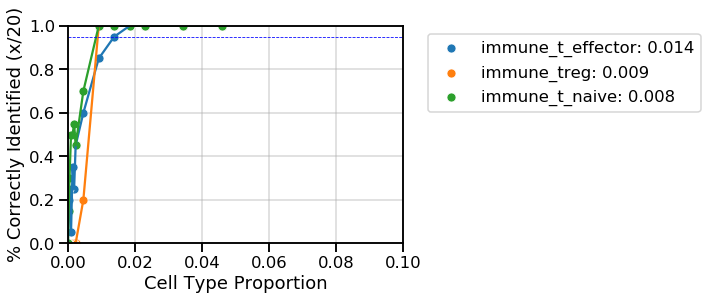

In [37]:
# t effector, t reg order must follow the order in which the predictions were made
lod95_detect_plot(titrating_celltypes = ['immune_t_effector', 'immune_treg', 'immune_t_naive'], 
                  titrating_celltype_proportion = TITRATION_LIST, 
                  deconvolution_preds = deconvolution_nnls , 
                  detection_threshold = 0.005, 
                  lod=0.95)

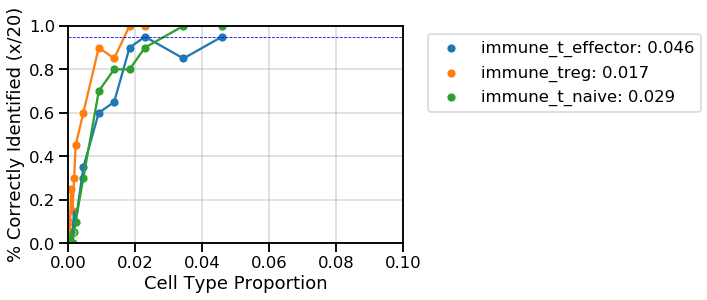

In [38]:
lod95_within_proportion_plot(titrating_celltypes = ['immune_t_effector', 'immune_treg', 'immune_t_naive'], 
                              titrating_celltype_proportion = TITRATION_LIST, 
                              deconvolution_preds = deconvolution_nnls, 
                              tolerance = 0.3, 
                              lod=0.95)


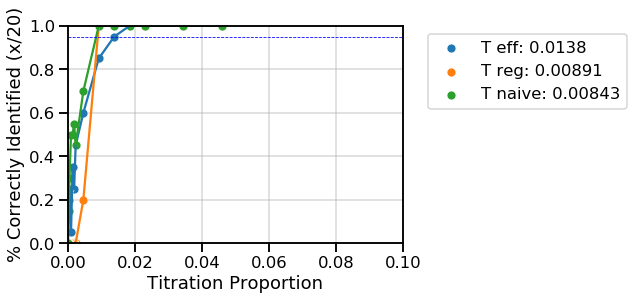

In [47]:
# t effector, t reg order must follow the order in which the predictions were made
dcnv.lod95_detect_plot(names=['T eff', 'T reg', 'T naive'],
                  titrating_celltypes = ['immune_t_effector', 'immune_treg', 'immune_t_naive'], 
                  titrating_celltype_proportion = TITRATION_LIST, 
                  deconvolution_preds = deconvolution_nnls, 
                  detection_threshold = 0.005, 
                  lod=0.95)